In [1]:
import kagglehub
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split

from utils import load_images

from sklearn.metrics import confusion_matrix


/Users/keerthireddy/Documents/rc/mushrooms/.mushroomvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explore data

In [ ]:
# base_dir = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
# print("Path to dataset files:", path)
base_dir = "/Users/keerthireddy/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1/Mushrooms"
images = load_images(base_dir)

In [ ]:
# what's a good size for the images?
sizes = [row["image"].size for row in images]
widths, heights = zip(*sizes)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Dimensions Distribution')

# Add a line for square images (y=x) for reference
min_dim = min(min(widths), min(heights))
max_dim = max(max(widths), max(heights))
plt.plot([min_dim, max_dim], [min_dim, max_dim], 'r--', alpha=0.5, label='Square (1:1)')

z = np.polyfit(widths, heights, 1)  # 1 for linear fit
p = np.poly1d(z)
plt.plot(widths, p(widths), 'g-', alpha=0.5, label=f'Best fit (y = {z[0]:.2f}x + {z[1]:.2f})')


plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# compared with resize and center crop as square vs as rectangle (.6:1) as that's the most common shape
# square seems to capture enough mushroom 
# transform some images and look through them to see if this is a reasonable option or if we lose too much info
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(150), transforms.CenterCrop((90, 150))])
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224), transforms.CenterCrop((224,224))])

for data in images[200:200+15]:
    display(data["image"])
    tensor = transform(data["image"])
    img = F.to_pil_image(tensor)
    display(img)

# square seems fine - we can adjust size up or down depending on how things go 

In [ ]:
# how many images are RGB?
sum([1 for data in images if data["image"].mode == "RGB"])/len(images)
# vast majority, so made RBG only it the default in load_images to drop others
# note that now this will show up as 100%

# Test Model & Explore Data

In [12]:
import random
import torch
from utils import create_data_lists, make_dataloader
from cnn import MushroomClassifier
from trainer import MushroomTrainer
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# recreate model and trainer 

SEED = 81
random.seed(SEED)
torch.manual_seed(SEED)
base_dir = "/Users/keerthireddy/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1/Mushrooms"

print("creating data lists")
train_data, val_data, test_data, labels = create_data_lists(base_dir)
num_classes = len({data["genus"] for data in train_data})

print("creating dataloaders")
# make dataloaders
val_dataloader = make_dataloader(val_data)
test_dataloader = make_dataloader(test_data)

print("making neural net and trainer")

shroom_classifier = MushroomClassifier(num_classes)
shroom_trainer = MushroomTrainer(
    shroom_classifier,
    train_data,
    val_dataloader,
    test_dataloader,
    num_epochs=15,
    seed=SEED,
    labels=labels
)

checkpoint = shroom_trainer.load_checkpoint("./models/model_2/epoch_10.pth", seed=SEED)

creating data lists
Skipping corrupted image /Users/keerthireddy/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1/Mushrooms/Russula/092_43B354vYxm8.jpg: image file is truncated (92 bytes not processed)
creating dataloaders
Dataset creation time: 0.003532210015691817
Dataset creation time: 0.0002053479547612369
making neural net and trainer
loading checkpoint ./models/model_2/epoch_10.pth


In [5]:
# run a sample of the test data 

num_to_test = 32
inputs, targets = next(iter(test_dataloader))[:num_to_test]
shroom_trainer.model.eval()
with torch.no_grad():
    preds = shroom_trainer.model.forward(inputs)
    loss = shroom_trainer.loss_fn(preds, targets)
shroom_trainer.model.train()
probs = torch.softmax(preds, dim=1)


In [ ]:
# look through images 

for i, data in enumerate(inputs):
    img = F.to_pil_image(data)
    display(img)
    for j, prob in enumerate(probs[i]):
        print(f"{labels[j]}: {prob*100}")
    print(f"Target: {targets[i]}, {labels[targets[i]]}")

In [16]:
# run all the test data 

shroom_trainer.model.eval()
total_loss = 0
correct = 0
correct_top_3 = 0
total = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        preds = shroom_trainer.model.forward(inputs)
        loss = shroom_trainer.loss_fn(preds, targets)
        total_loss += loss.item()

        predicted = torch.argmax(preds, dim=1)
        correct += (predicted == targets).sum().item()

        _, top3_indices = torch.topk(preds, k=3, dim=1)
        for i, target in enumerate(targets):
            if target in top3_indices[i]:
                correct_top_3 += 1

        total += targets.size(0)
        all_preds.append(preds)
        all_targets.append(targets)

avg_loss = total_loss / len(test_dataloader)
accuracy = (correct / total) * 100
top3_accuracy = (correct_top_3 / total) * 100

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

shroom_trainer.model.train()

print(f"Accuracy: {accuracy}, Top3: {top3_accuracy}")

Accuracy: 63.853028798411124, Top3: 87.88480635551143


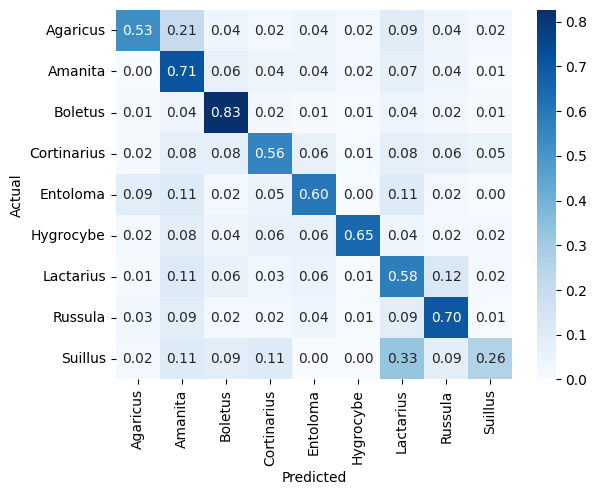

In [41]:
# make a confusion matrix 

class_predictions = all_preds.argmax(dim=1).numpy()  
all_targets = all_targets.numpy() 

conf_matrix = confusion_matrix(all_targets, class_predictions, normalize="true")
# conf_matrix = confusion_matrix(all_targets, class_predictions, normalize="pred")

fig, ax = plt.subplots()
ax = sns.heatmap(conf_matrix, annot=True, fmt='.2f', xticklabels = labels, yticklabels = labels, cmap="Blues")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- There's not a clear relationship here between num of samples and accuracy
- Looking at some common confusions:
  - Suilus vs Lactarius - at least to the naked eye, gill shape seems v important
  - Agaricus vs Amanita - also seems to be a clear textural difference (not gills though)
Seems like it could be high value to 1) increase the res of the images (kind of low right now) and 2) ensure the model has what it needs to capture fine-grained image features